# Testing the mesh with dirichlet BC

In [431]:
from fenics import *

In [432]:
#from dolfin import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri
import numpy as np

In [433]:
mesh = Mesh()
# with XDMFFile(MPI.comm_world, "mesh/mesh.xdmf") as file:
#     file.read(mesh)


# mvc = MeshValueCollection("size_t", mesh, 2) 
# with XDMFFile("mesh/mf.xdmf") as file:
#     file.read(mvc)
# mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)


In [434]:
with XDMFFile("mesh/mesh.xdmf") as infile:
    infile.read(mesh)

# mvc = MeshValueCollection("size_t", mesh, 2) 
# with XDMFFile("mesh/mf.xdmf") as infile:
#     infile.read(mvc)
# mf = cpp.mesh.MeshFunctionSizet(mesh, mvc)

In [435]:
# Define subdomain markers and the corresponding subdomains for materials
materials = MeshFunction('size_t', mesh, mesh.topology().dim(), 0)
# Define the material properties as functions, assuming 1 everywhere as you said
k = Constant(1.0)  # Thermal conductivity

In [436]:
# Define function space
V = FunctionSpace(mesh, 'CG', 1)

# Define boundary conditions
u_D_top_tile = Constant(1.0)  # Example value for top tile
u_D_pipeface = Constant(-1.0)  # Example value for pipeface

In [437]:



# Create a MeshFunction for boundary marking
boundary_markers = MeshFunction('size_t', mesh, mesh.topology().dim() - 1, 0)

# Mark the boundary


In [438]:
tol = 1E-5  # tolerance for point location
class TopTile(SubDomain):
    """
        For the bc_top_tile, the condition is straightforward since it's applied at z = 0.025
    """
    def inside(self, x, on_boundary):
        #return on_boundary and near(x[2], 0.025, eps=1e-5)
        return np.isclose(x[2], 0.025, rtol=0.0, atol=1E-4)


class PipeFace(SubDomain):
    """
    define the PipeFace class for the boundary condition on the curved surface of the cylinder whose axis is parallel to the y-axis, and the center of the cylinder's cross-section in the x-z plane is at x=0.015 and z=0.01,
    and the radius of the cylinder is = 0.001.
    """
    def inside(self, x, on_boundary):
        # Center of the cylinder's cross-section in the XZ-plane
        x_center = 0.015  # provided x-coordinate of the center
        z_center = 0.01  # provided z-coordinate of the center
        radius = 0.01  # Radius of the cylinder
        
        # Calculate distance from the point to the cylinder's central axis in the XZ-plane
        distance_from_axis = np.sqrt((x[0] - x_center)**2 + (x[1] - z_center)**2)
        
        # Check if the point is on the boundary and exactly at the distance of the radius from the cylinder's central axis
        #return on_boundary and near(distance_from_axis, radius, eps=1e-5)
        return np.isclose(distance_from_axis, radius, rtol=0.0, atol=1E-5)

In [439]:
# Initialize the custom boundary condition object for the top tile and pipe face
top_tile = TopTile()
pipe_face = PipeFace()

top_tile.mark(boundary_markers, 1)
pipe_face.mark(boundary_markers, 2)


# Define the Dirichlet boundary condition for the pipe face using the updated class
bc_top_tile = DirichletBC(V, u_D_top_tile, boundary_markers, 1)#DirichletBC(V, u_D_top_tile, top_tile)
bc_pipeface = DirichletBC(V, u_D_pipeface, boundary_markers, 2)#DirichletBC(V, u_D_pipeface, pipe_face)

# Collect boundary conditions
bcs = [bc_top_tile]#, bc_pipeface]
#bcs = [bc_pipeface]

In [440]:
# Define variational problem for Laplace equation
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(0)  # Assuming zero source term for Laplace's equation
a = (inner(grad(u), grad(v)) - k**2* inner(u, v))*dx
L = inner(f, v) * dx

In [441]:
# Compute solution
u = Function(V)
solve(a == L, u, bcs)

  Solving linear variational problem.


In [442]:
# Save solution to file
with XDMFFile(MPI.comm_world, "output/solution.xdmf") as file:
    file.write(u)

In [443]:
# # To compute and write the gradient, you need to project it to a VectorFunctionSpace
# V_g = VectorFunctionSpace(mesh, 'P', 1)
# grad_u = project(grad(u), V_g)

# with XDMFFile(MPI.comm_world, "output/temperature_gradient.xdmf") as file:
#     file.write(grad_u)


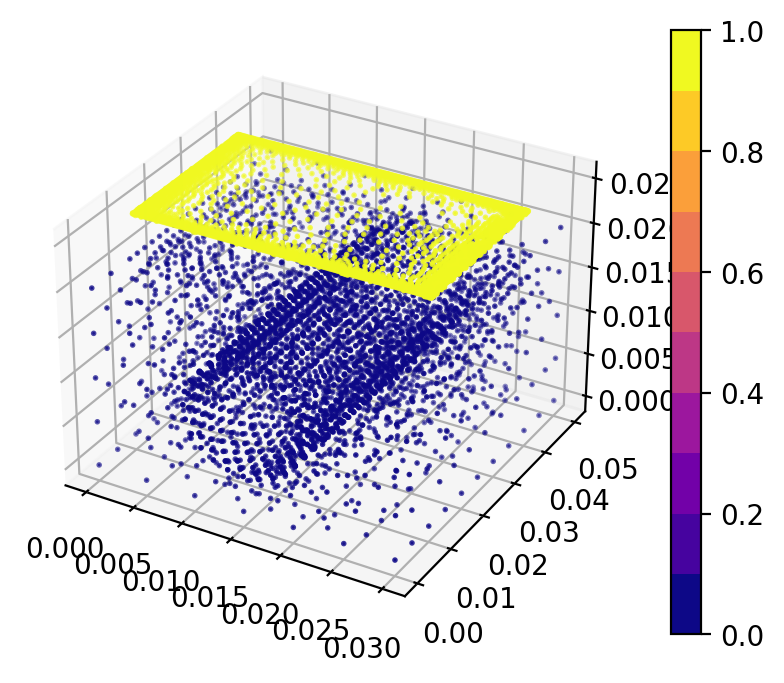

In [444]:
fig =plt.figure(dpi=200)
sc = plot(u, s=1, cmap=plt.get_cmap('plasma', 10))
fig.colorbar(sc)
plt.savefig('output/solution.png', dpi=500, bbox_inches='tight')